# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd
from skimage import io, measure, filters, transform, morphology
from tqdm.notebook import tqdm as tqdm

pixel_size = 0.161 # µm per pixel

### Comments by Soichi:

Below are a series of defined functions involved in the data analysis, from collecting all images used for the analysis to the image processing of stabilized microtubules as collected using TIRF. Briefly, `find_all_tiffs` locates all `.tif` TIRF images of microtubules. `filter_mts` performs the initial processing of images to find putative microtubules and connects microtubules that may have been broken during thresholding schemes. `border_clear` removes putative filaments that appear to reach the edge of the image border and therefore may be longer than can be measured in the image. `remove_circulars` and `remove_small` throws away putative filaments that do not appear as lines and are two small, respectively. The latter function is thresholded according to whether the object size is above the Nyquist criterion. `are2lines` determines whether two straight lines but of different angles can be drawn on a putative filament, which indicates two separate microtubules cross over each other. This is relayed to `remove_line_crossovers` which removes both filaments. All functions with the exception of `plotting_style` (used to set figure graphics preferences) and `find_all_tiffs` are implemented in `process_mt_images` and the lengths of filaments are extracted and implemented in a DataFrame that keeps other properties of the microtubules, including area, major and minor axis lengths, centroid, orientation, and perimeter. Perimeter is then used for the empirical cumulative distribution function with 25th, 50th (median), and 75th percentile written on the x-axis.

# Soichi Functions

In [2]:
def plotting_style():
    """
    Sets matplotlibs plotting style to the publication default. It returns a
    list of the preferred colors.
    """
    rc = {'axes.facecolor': '#e7d8b8',
          'axes.grid': False,
          'axes.frameon': True,
          'ytick.direction': 'out',
          'xtick.direction': 'out',
          'xtick.gridOn': True,
          'ytick.gridOn': True,
          'ytick.major.width':5,
          'xtick.major.width':5,
          'ytick.major.size': 5,
          'xtick.major.size': 5,
          'mathtext.fontset': 'stixsans',
          'mathtext.sf': 'sans',
          'legend.frameon': True,
          'legend.facecolor': '#FFEDCE',
          'figure.dpi': 150,
          'xtick.color': 'k',
          'ytick.color': 'k'}
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('mathtext', fontset='stixsans', sf='sans')
    sns.set_style('dark', rc=rc)
    mpl.rcParams['image.cmap'] = 'gray'
    mpl.rcParams['xtick.labelsize']=16
    mpl.rcParams['ytick.labelsize']=16
    mpl.rcParams['axes.labelsize']=20
    mpl.rcParams['figure.titlesize']=20

plotting_style()

def find_all_tiffs(root_directory):
    """
    Finds all .tif files in root_directory and lists paths. Does not
    work if .tif files are further embedded in subdirectories within
    root_directory
    """
    tiff_list = []

    for root_path, _, files in os.walk(root_directory):
        for f in files:
            if f.endswith('.tif'):
                tiff_list.append(os.path.join(root_path,f))

    return tiff_list

def filter_mts(image, block_size=5, mask_size=5, yen=False):
    """
    Image processing for individual MT image file. Images are first normalized
    before applying local thresholding to correct for nonuniform image background.
    Global thresholding is then performed to obtain the thresholded image of
    putative microtubules. Further processing is performed where small breaks
    in filaments are reconnected again.
    """
    image_norm = (image - image.min()) / (image.max() - image.min())

    thresh_niblack = filters.threshold_niblack(image_norm, window_size=block_size,
                                                k=0.001)

    # Rather than applying the threshold to the image to create a binary
    # image, the threshold array thresh_niblack thickens the MTs, reducing
    # filament break-up. This is used then in the Otsu thresholding to
    # produce the binary image.
    thresh_otsu = filters.threshold_otsu(thresh_niblack)
    im_thresh = (thresh_niblack > thresh_otsu)

    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)

    if yen==True:
        im_subt = image - im_closed
        im_yen = filters.threshold_yen(im_subt)
        im_filtered = im_subt > im_yen
    else:
        im_filtered = im_closed.copy()

    return im_filtered

def border_clear(im_label, edge=3):
    """
    Remove objects within `edge` pixels from the image boundary

    Input
    -------
    im_label : labeled image where objects in the image are assigned positive integer value
    edge : maximum number of pixels that putative filament needs to be away from the image boundary to be rejected
    """
    im_border = np.copy(im_label)

    border = np.ones(np.shape(im_label))
    border[edge:-1*edge,edge:-1*edge] -= 1

    for n in np.unique(im_border):
        if np.any(border * [im_border==n+1]):
            im_border[im_border==n+1] = 0

    return im_border

def determine_count_nums(im_label):
    """
    Obtains maximum number of objects in the labeled image. Used to determine
    if background subtraction and thresholding must be performed on top of Niblack
    thresholding scheme.
    """
    unique, counts = np.unique(im_label, return_counts=True)

    return unique, counts

def remove_small(im_label, area_thresh=10):
    im_sized = np.copy(im_label)

    unique, counts = determine_count_nums(im_label)

    # Create dictionary except for 0 (background)
    dict_area = dict(zip(unique,counts))

    for label in unique:
        if label > 0 and dict_area[label]<=area_thresh:
            im_sized[im_sized==label] = 0
    
    return im_sized

def remove_circulars(im_label, eccen_thresh=0.8):
    im_eccen = im_label.copy()

    im_props = measure.regionprops_table(im_eccen,
                                        properties=['label','eccentricity'])
    df = pd.DataFrame(im_props)

    for n in np.unique(im_eccen):
        if df[df['label']==n]['eccentricity'].values < eccen_thresh:
            im_eccen[im_eccen==n] = 0

    return im_eccen

def are2lines(mt_segment, min_dist=9, min_angle=75):
    """
    Determine if putative microtubules are two microtubules. Uses
    Hough straight lines to determine if there are at least 2
    lines that can be drawn from the putative filament.
    
    Input
    -------
    mt_segment : (M, N), ndarray; cropped region about the putative
                 microtubule
    min_angle : int, minimum angle (in degrees) separating lines (default 75)
    
    Return
    -------
    len(angles)==2 : bool, determines whether there is a crossover
    """
    test_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
    h, theta, d = transform.hough_line(mt_segment, theta=test_angles)

    _, angles, _ = transform.hough_line_peaks(h, theta, d, 
                                                min_distance=min_dist,
                                                min_angle=min_angle,
                                                num_peaks=2)

    return len(angles)==2

def remove_line_crossovers(image, min_dist=9, min_angle=75, padding=3):
    """
    Removes microtubules that cross over in the images. 
    Input
    -------
    image : (M, N), ndarray; image from which MT crossovers are removed
    min_angle : int, minimum angle (in degrees) separating lines (default 30)
    padding : int, padding around cropped MT segments

    Return
    -------
    im_cleaned : (M, N), ndarray; image with MT crossovers removed
    """
    im_cleaned = image.copy()

    for n in np.unique(image)[1:]:
        x,y = np.where(image==n)
        mt_segment = image[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]
        
        if are2lines(mt_segment, min_dist=min_dist, min_angle=min_angle):
            im_cleaned = np.where(im_cleaned==n, 0, im_cleaned)

    return im_cleaned

def process_mt_images(image, block_size=3, mask_size=3, count_thresh=200, edge=3, area_thresh=10, min_dist=9, min_angle=75, padding=3):
    im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size)
    im_label, n_labels = measure.label(im_filtered, return_num=True)
    # Determine if Yen thresholding background subtraction is necessary
    unique, _ = determine_count_nums(im_label)
    if unique[-1] > count_thresh:
        im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size, yen=True)
        im_label, n_labels = measure.label(im_filtered, return_num=True)
    im_internal = border_clear(im_label, edge=edge)
    im_sized = remove_small(im_internal, area_thresh=area_thresh)
    im_thinned = morphology.thin(im_sized)
    im_relabel = measure.label(im_thinned)
    im_noxovers = remove_line_crossovers(im_relabel, min_dist=min_dist,
                                        min_angle=min_angle, padding=padding)

    return im_noxovers

# Run and Plot Soichi Version:

In [3]:
root = '../../data/gliding/2023-03-24_Gliding/940/2023-Mar24_AnaGliding_Ncd-cherry-MT488_ATP940_lowATPload_4.5min_1/images'
tiff_list = find_all_tiffs(root)

In [4]:
df_props = pd.DataFrame()
for image_file in tqdm(tiff_list):
    image = io.imread(image_file)
    im_processed = process_mt_images(image, block_size=3, 
                                    mask_size=3, edge=5, 
                                    area_thresh=10, min_dist=9,
                                    min_angle=75, padding=3)
    im_props = measure.regionprops_table(im_processed, image,
                                    properties=['area', 'major_axis_length',
                                                'minor_axis_length','centroid',
                                                'orientation', 'eccentricity',
                                                'label', 'perimeter'])
    _df = pd.DataFrame(im_props)
    _df['tiff_file'] = image_file
    # Remove non-existent objects from thinning to single-pixel size
    _df = _df[_df['perimeter']>0]
    _df['perimeter (um)'] = _df['perimeter'] * pixel_size
    df_props = df_props.append(_df, ignore_index=True)

#df_props.to_csv('../../analyzed_data/gliding/MT_lengths.csv', sep=',');

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_6371/2117321872.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_props = df_props.append(_df, ignore_index=True)
/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_6371/2117321872.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_props = df_props.append(_df, ignore_index=True)
/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_6371/2117321872.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_props = df_props.append(_df, ignore_index=True)
/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_6371/2117321872.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

[Text(0, 0.0, '0.0'),
 Text(0, 0.25, '0.25'),
 Text(0, 0.5, '0.50'),
 Text(0, 0.75, '0.75'),
 Text(0, 1.0, '1.0')]

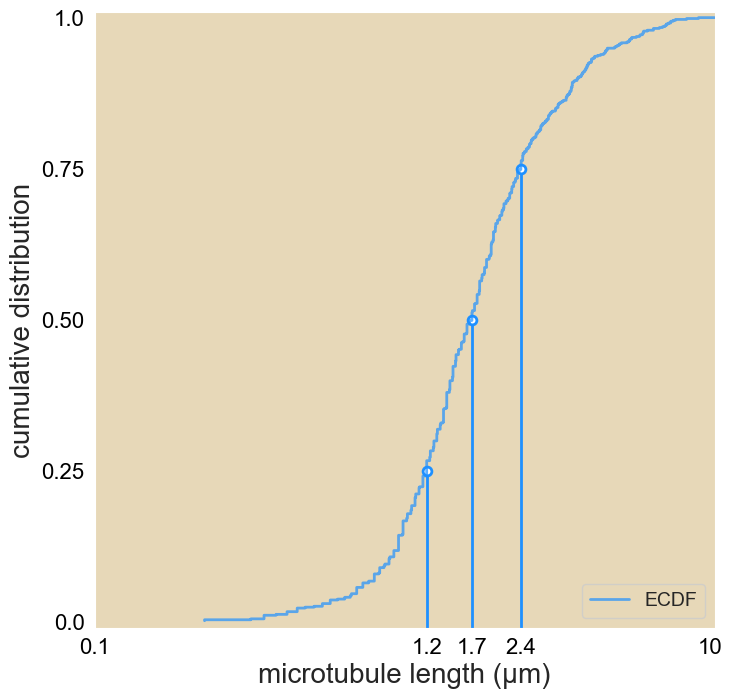

In [5]:
mt_length = np.sort(df_props['perimeter (um)'].values)
ecdf = np.arange(1, len(mt_length)+1, 1) /len(mt_length)

q_25 = np.percentile(mt_length, 25)
q_50 = np.percentile(mt_length, 50)
q_75 = np.percentile(mt_length, 75)

fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.step(mt_length, ecdf, label='ECDF', color='dodgerblue', lw=2, zorder=4, alpha=0.7)

ax.scatter(q_25, 0.25, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)
ax.scatter(q_50, 0.50, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)
ax.scatter(q_75, 0.75, s=40, zorder=3, facecolor='w', edgecolor='dodgerblue', lw=2)

ax.axvline(q_25, 0, 0.25, color='dodgerblue', lw=2)
ax.axvline(q_50, 0, 0.50, color='dodgerblue', lw=2)
ax.axvline(q_75, 0, 0.75, color='dodgerblue', lw=2)

ax.set_xlim([0.1,np.max(mt_length)])
ax.set_ylim([-0.01,1.01])
ax.set_xlabel('microtubule length (µm)', fontsize=20)
ax.set_ylabel('cumulative distribution', fontsize=20)
ax.legend(fontsize=14, loc=4)
ax.set_xscale('log')

ax.set_xticks([0.1, q_25, q_50, q_75, 10])
ax.set_xticklabels(['0.1', '%.1f' %q_25, '%.1f' %q_50, '%.1f' %q_75, '10'])

ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0.0', '0.25', '0.50', '0.75', '1.0'])

#plt.savefig('../figures/SIFigX_MT_length_RB_manuscript.pdf', bbox_inches='tight',facecolor='white')

# Ana Breakdown for understanding

## Import Image

test image:

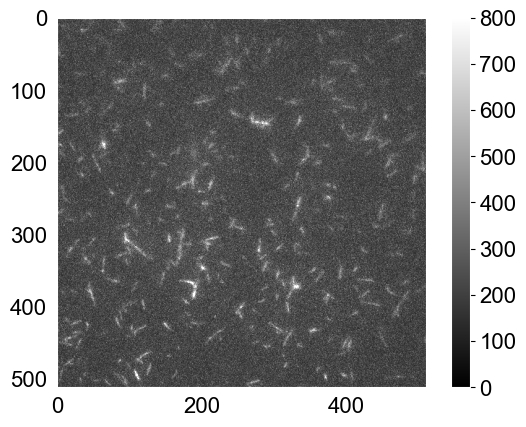

In [6]:
image = io.imread(tiff_list[2])
plt.imshow(image, vmin=0, vmax = 800)
plt.colorbar()

## Image Processing

normalize the image

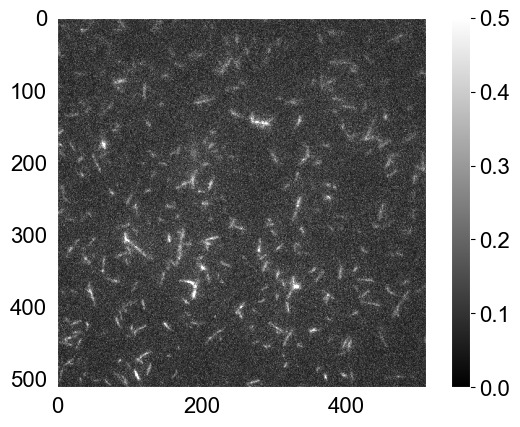

In [7]:
image_norm = (image - image.min()) / (image.max() - image.min())
plt.imshow(image_norm, vmin=0, vmax=0.5)
plt.colorbar()

Niblack thresholding - local thresholding rather than global - often used for text

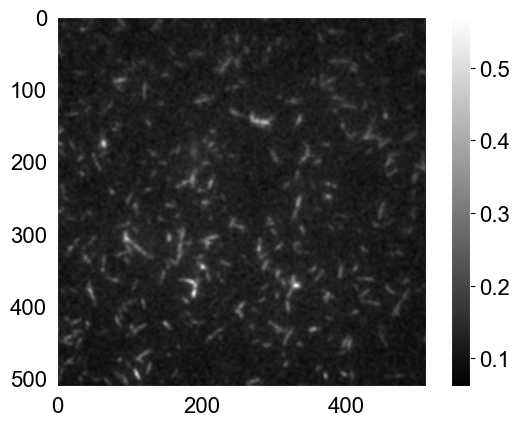

In [8]:
block_size = 5
thresh_niblack = filters.threshold_niblack(image_norm, window_size=block_size, k=0.001)
plt.imshow(thresh_niblack)
plt.colorbar()

Otsu threshold --> soichi's note: Rather than applying the threshold to the image to create a binary image, the threshold array thresh_niblack thickens the MTs, reducing filament break-up. This is used then in the Otsu thresholding to produce the binary image.

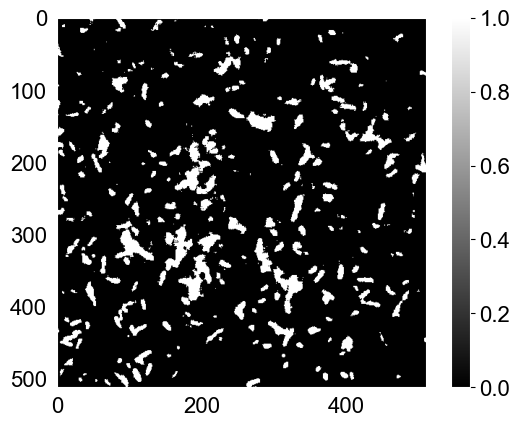

In [9]:
thresh_otsu = filters.threshold_otsu(thresh_niblack)
im_thresh = (thresh_niblack > thresh_otsu)
plt.imshow(im_thresh)
plt.colorbar()

Mask and close?

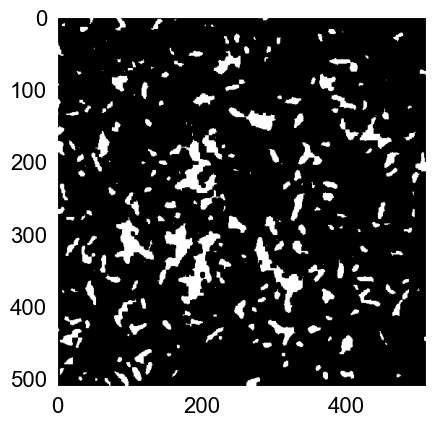

In [10]:
mask_size=5
mask = morphology.square(mask_size)
im_closed = morphology.closing(im_thresh, selem=mask)
plt.imshow(im_closed)

Set the filtered image to be the closed image:

In [11]:
im_filtered = im_closed.copy()

## Determine if further background subtraciton and processing is required (Yen thresholding?)Defines groups of neighboring pixels

Defines groups of neighboring pixels

number of regions = 250


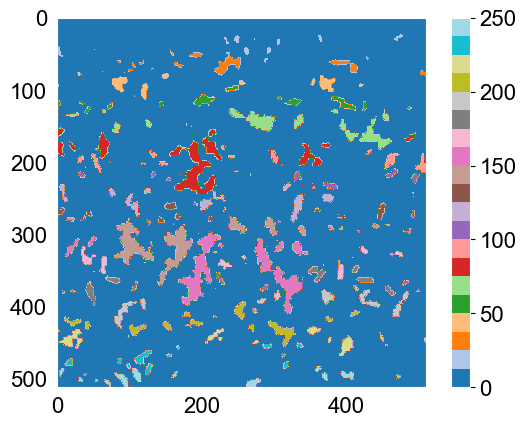

In [12]:
im_label, n_labels = measure.label(im_filtered, return_num=True)
print('number of regions = ' + str(n_labels))
plt.imshow(im_label, cmap = 'tab20')
plt.colorbar();

Determine the number of objects, soichi note - Obtains maximum number of objects in the labeled image. Used to determine if background subtraction and thresholding must be performed on top of Niblack thresholding scheme.

In [13]:
unique, _ = np.unique(im_label, return_counts=True)

Side note: the sum of the underscore (sometiems denoted count) in the np.unique function gives the amount of pixels per unique region which in total sums to the total number of pixels in the image. The biggest region is the background which is one continuous region.

In [14]:
np.sum(_), np.shape(image)[0]**2

(262144, 262144)

Soichi checks if the number of MT found is greater than some threshold which he sets to 200.. why? If it is, then he performs a second thresholding technique to remove background 

In [15]:
count_thresh=200
unique[-1] > count_thresh

True

Ok so it is bigger in this case, lets do the Yen thresholding: First remove the microtubule regions we found in im_closed from the original image: 

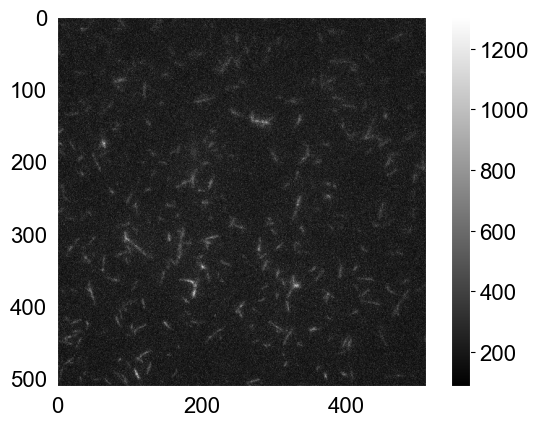

In [16]:
im_subt = image - im_closed
plt.imshow(im_subt)
plt.colorbar()

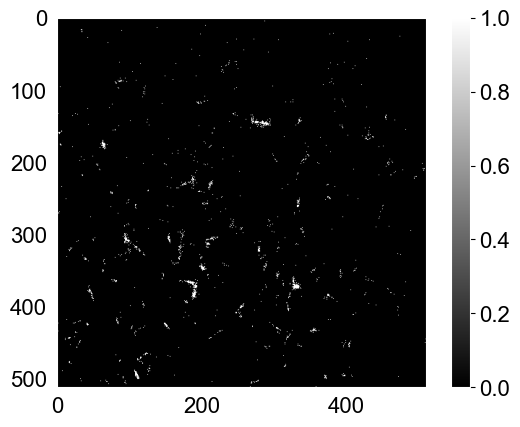

In [19]:
im_yen = filters.threshold_yen(im_subt)
im_filtered_yen = im_subt > im_yen
plt.imshow(im_filtered_yen)
plt.colorbar()

So now that we have the yen filter, lets get the number of rgions identified:

In [25]:
im_label_yen, n_labels_yen = measure.label(im_filtered_yen, return_num=True)
print('Number of regions including background: ' +str(np.unique(im_label_yen)[-1]))

Number of regions including background: 745


In [ ]:
if unique[-1] > count_thresh:
        im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size, yen=True)
        im_label, n_labels = measure.label(im_filtered, return_num=True)

In [42]:
def determine_count_nums(im_label):
    """
    Obtains maximum number of objects in the labeled image. Used to determine
    if background subtraction and thresholding must be performed on top of Niblack
    thresholding scheme.
    """
    unique, counts = np.unique(im_label, return_counts=True)

    return unique, counts

Signature: filter_mts(image, block_size=5, mask_size=5, yen=False)
Docstring:
Image processing for individual MT image file. Images are first normalized
before applying local thresholding to correct for nonuniform image background.
Global thresholding is then performed to obtain the thresholded image of
putative microtubules. Further processing is performed where small breaks
in filaments are reconnected again.
File:      /var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_1917/3909703843.py
Type:      function

In [ ]:
def process_mt_images(image, block_size=3, mask_size=3, count_thresh=200, edge=3, area_thresh=10, min_dist=9, min_angle=75, padding=3):
    im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size)
    im_label, n_labels = measure.label(im_filtered, return_num=True)
    # Determine if Yen thresholding background subtraction is necessary
    unique, _ = determine_count_nums(im_label)
    if unique[-1] > count_thresh:
        im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size, yen=True)
        im_label, n_labels = measure.label(im_filtered, return_num=True)
    im_internal = border_clear(im_label, edge=edge)
    im_sized = remove_small(im_internal, area_thresh=area_thresh)
    im_thinned = morphology.thin(im_sized)
    im_relabel = measure.label(im_thinned)
    im_noxovers = remove_line_crossovers(im_relabel, min_dist=min_dist,
                                        min_angle=min_angle, padding=padding)

    return im_noxovers